# Required libraries

In [ ]:
!pip install opencv-python
!pip install opencv-contrib-python
!pip install numpy
!pip install matplotlib
# !pip install scikit-image
# !pip install colorthief
# !pip install stitching

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
# import stitching

# Pipeline Building Functions

In [2]:
def getDominantColorFromImage(img,visulize=False):
    average = img.mean(axis=0).mean(axis=0)

    pixels = np.float32(img.reshape(-1, 3))

    n_colors = 4
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
    flags = cv2.KMEANS_RANDOM_CENTERS

    _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
    _, counts = np.unique(labels, return_counts=True)

    dominant = palette[np.argmax(counts)]
    if visulize:
        avg_patch = np.ones(shape=img.shape, dtype=np.uint8)*np.uint8(average)

        indices = np.argsort(counts)[::-1]   
        freqs = np.cumsum(np.hstack([[0], counts[indices]/float(counts.sum())]))
        rows = np.int_(img.shape[0]*freqs)

        dom_patch = np.zeros(shape=img.shape, dtype=np.uint8)
        for i in range(len(rows) - 1):
            dom_patch[rows[i]:rows[i + 1], :, :] += np.uint8(palette[indices[i]])
            
        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,6))
        ax0.imshow(avg_patch)
        ax0.set_title('Average color')
        ax0.axis('off')
        ax1.imshow(dom_patch)
        ax1.set_title('Dominant colors')
        ax1.axis('off')
        plt.show(fig)

    return dominant,counts

In [3]:
def remove_noise(gray, num):
    Y, X = gray.shape
    nearest_neigbours = [[
        np.argmax(
            np.bincount(
                gray[max(i - num, 0):min(i + num, Y), max(j - num, 0):min(j + num, X)].ravel()))
        for j in range(X)] for i in range(Y)]
    result = np.array(nearest_neigbours, dtype=np.uint8)

    return result

def dominantColorToMask(img,dominantColor,ColorThreshold=20,noiseRemovingLevel=8):
    lowerColor= dominantColor - ColorThreshold
    upperColor = dominantColor + ColorThreshold

    maskRGB = ~cv2.inRange(img, lowerColor, upperColor)
    Clean_maskRGB = remove_noise(maskRGB,noiseRemovingLevel)


    return Clean_maskRGB



# The Pipeline

In [4]:
def pipe_line(frame):
    
    crop_ratio=0.3
    IMAGE_H = int(432*(1-crop_ratio))
    IMAGE_W = 768

    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        
    resized_img = cv2.resize(img, None, fx = 0.4, fy = 0.4)

    bilateral = cv2.bilateralFilter(resized_img[IMAGE_H:, 0:IMAGE_W], 15, 75, 75) 
    dominant,counts = getDominantColorFromImage(bilateral,visulize=False) 


    Clean_maskRGB = dominantColorToMask(resized_img,dominant,noiseRemovingLevel=7,ColorThreshold=20)
    resultRGB = cv2.bitwise_and(resized_img, resized_img, mask=Clean_maskRGB)

    coun,hire=cv2.findContours(Clean_maskRGB,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    coun = sorted(coun, key=cv2.contourArea)
    
    coef_y = img.shape[0] / resized_img.shape[0]
    coef_x = img.shape[1] / resized_img.shape[1]

    for contour in coun:
        contour[:, :, 0] = contour[:, :, 0] * coef_x
        contour[:, :, 1] = contour[:, :,  1] * coef_y

   
    result = cv2.drawContours(img.copy(),coun[:-1],-1,(0,0,255),2)

    result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)

    return result


# Video Example

In [ ]:
cap = cv2.VideoCapture('data\\sections.mov')
 
# Check if camera opened successfully
if (cap.isOpened()== False): 
     print("Error opening video stream or file")

frame_number=0


while(cap.isOpened()):

  ret, frame = cap.read()
  if ret == True:
    frame_number+=1

    if frame_number>72: # pass the black screan in the begenning
        
        result = pipe_line(frame)
        print(str(frame_number-73)+".png is saved")
        cv2.imwrite(str(frame_number-73)+".png",result)

  else: 
    break
 
# When everything done, release the video capture object
cap.release()
 
# Closes all the frames


# Image Examples

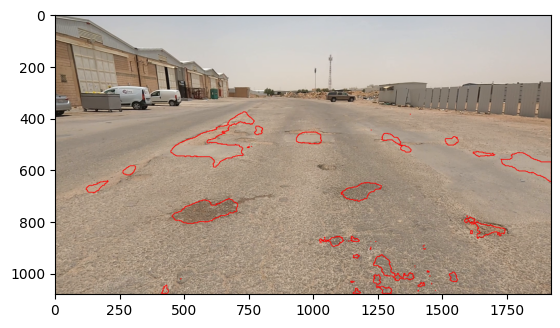

In [15]:
img = cv2.imread("data\\png\\Scene 1\\0010.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

result = pipe_line(img)

plt.imshow(result)



# Bird-Eye View (in testing)
### It will be used to estemate the area of pothole 
### Also it will be used to generate images for all the road (stiched image), this will be used in future and combined with GPS to be compared with the new live images to detect the new apeered potholes.

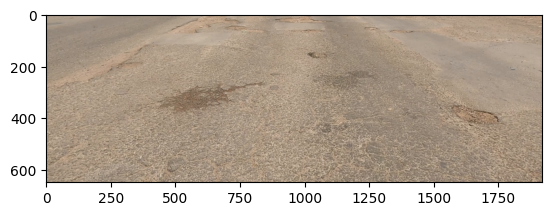

In [23]:
img = cv2.imread("data\\png\\Scene 1\\0010.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

crop_ratio=0.6
IMAGE_H = int(img.shape[0]*(1-crop_ratio))
IMAGE_W = img.shape[1]

slope= 0.7

src = np.float32([[0, 0], [IMAGE_W, 0], [0, IMAGE_H],[IMAGE_W, IMAGE_H]])
dst = np.float32([[0, 0],[IMAGE_W, 0], [int(IMAGE_W*(slope/2)), IMAGE_H], [int(IMAGE_W*(1-slope/2)), IMAGE_H]])
M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
Minv = cv2.getPerspectiveTransform(dst, src) # Inverse transformation

imgs_cropped=[]
imgs_wrapped=[]

cropped_image = img[IMAGE_H:, 0:IMAGE_W].copy() # Apply np slicing for ROI crop
warped_img = cv2.warpPerspective(cropped_image, M, (IMAGE_W, int(img.shape[0]*(crop_ratio)))) # Image warping
imgs_cropped.append(cropped_image)
kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
warped_img = cv2.filter2D(warped_img, -1, kernel)
imgs_wrapped.append(warped_img)#[:, int(IMAGE_W*(slope/2)):int(IMAGE_W*(1-slope/2))])


# for val in src:
#     cv2.circle(cropped_image,(int(val[0]),int(val[1])),40,(0,255,255),-1)

plt.imshow(imgs_cropped[-1]) # Show results
plt.show()


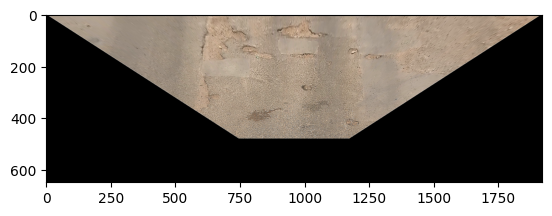

In [24]:
plt.imshow(imgs_wrapped[-1]) # Show results
plt.show()
